In [1]:
from typing import List, NoReturn, Union, Tuple, Optional, Text, Generic, Callable, Dict

import numpy as np 
import pandas as pd
from sklearn import *
import lightgbm as lgb
import optuna.integration.lightgbm as lgbopt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()

pd.set_option("display.precision", 8)

from functools import partial
import scipy as sp

import os
from sklearn.metrics import f1_score

import pywt 
from statsmodels.robust import mad

import scipy
from scipy import signal
from scipy.signal import butter, deconvolve, find_peaks, peak_widths, peak_prominences

from numpy.fft import *

import time
import math
from numba import jit
from math import log, floor
from sklearn.neighbors import KDTree

import itertools
import warnings
import time
import pywt
import os
import gc

train = pd.read_csv('/Users/siero5335/channel/train_clean.csv')
test = pd.read_csv('/Users/siero5335/channel/test_clean.csv')

sample_submission = pd.read_csv('/Users/siero5335/channel/sample_submission.csv')

In [2]:
def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def high_pass_filter(x, low_cutoff=1000, sample_rate=10000):

    nyquist = 0.5 * sample_rate
    norm_low_cutoff = low_cutoff / nyquist
    print(norm_low_cutoff)
    sos = butter(10, Wn=[norm_low_cutoff], btype='highpass', output='sos')
    filtered_sig = signal.sosfilt(sos, x)

    return filtered_sig

def denoise_signal( x, wavelet='db4', level=1):
    
    coeff = pywt.wavedec( x, wavelet, mode="per" )
    sigma = (1/0.6745) * maddest( coeff[-level] )
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode='hard' ) for i in coeff[1:] )
    return pywt.waverec( coeff, wavelet, mode='per' )

train['signal_wave'] = denoise_signal(train['signal'])
test['signal_wave'] = denoise_signal(test['signal'])

def filter_signal(signal, threshold=1e8):
    fourier = rfft(signal)
    frequencies = rfftfreq(signal.size, d=20e-3/signal.size)
    fourier[frequencies > threshold] = 0
    return irfft(fourier)

train['signal_FFT_1e5'] = filter_signal(train['signal'], threshold=5e3)
test['signal_FFT_1e5'] = filter_signal(test['signal'], threshold=5e3)

In [3]:
def _embed(x, order=3, delay=1):
    N = len(x)
    if order * delay > N:
        raise ValueError("Error: order * delay should be lower than x.size")
    if delay < 1:
        raise ValueError("Delay has to be at least 1.")
    if order < 2:
        raise ValueError("Order has to be at least 2.")
    Y = np.zeros((order, N - (order - 1) * delay))
    for i in range(order):
        Y[i] = x[i * delay:i * delay + Y.shape[1]]
    return Y.T

all = ['perm_entropy', 'spectral_entropy', 'svd_entropy', 'app_entropy',
       'sample_entropy']


def perm_entropy(x, order=3, delay=1, normalize=False):
    x = np.array(x)
    ran_order = range(order)
    hashmult = np.power(order, ran_order)
    # Embed x and sort the order of permutations
    sorted_idx = _embed(x, order=order, delay=delay).argsort(kind='quicksort')
    # Associate unique integer to each permutations
    hashval = (np.multiply(sorted_idx, hashmult)).sum(1)
    # Return the counts
    _, c = np.unique(hashval, return_counts=True)
    # Use np.true_divide for Python 2 compatibility
    p = np.true_divide(c, c.sum())
    pe = -np.multiply(p, np.log2(p)).sum()
    if normalize:
        pe /= np.log2(factorial(order))
    return pe

In [4]:
def _log_n(min_n, max_n, factor):
    max_i = int(floor(log(1.0 * max_n / min_n) / log(factor)))
    ns = [min_n]
    for i in range(max_i + 1):
        n = int(floor(min_n * (factor ** i)))
        if n > ns[-1]:
            ns.append(n)
    return np.array(ns, dtype=np.int64)

def _higuchi_fd(x, kmax):
    n_times = x.size
    lk = np.empty(kmax)
    x_reg = np.empty(kmax)
    y_reg = np.empty(kmax)
    for k in range(1, kmax + 1):
        lm = np.empty((k,))
        for m in range(k):
            ll = 0
            n_max = floor((n_times - m - 1) / k)
            n_max = int(n_max)
            for j in range(1, n_max):
                ll += abs(x[m + j * k] - x[m + (j - 1) * k])
            ll /= k
            ll *= (n_times - 1) / (k * n_max)
            lm[m] = ll
        # Mean of lm
        m_lm = 0
        for m in range(k):
            m_lm += lm[m]
        m_lm /= k
        lk[k - 1] = m_lm
        x_reg[k - 1] = log(1. / k)
        y_reg[k - 1] = log(m_lm)
    higuchi, _ = _linear_regression(x_reg, y_reg)
    return higuchi


def higuchi_fd(x, kmax=10):
    x = np.asarray(x, dtype=np.float64)
    kmax = int(kmax)
    return _higuchi_fd(x, kmax)

def _linear_regression(x, y):
    n_times = x.size
    sx2 = 0
    sx = 0
    sy = 0
    sxy = 0
    for j in range(n_times):
        sx2 += x[j] ** 2
        sx += x[j]
        sxy += x[j] * y[j]
        sy += y[j]
    den = n_times * sx2 - (sx ** 2)
    num = n_times * sxy - sx * sy
    slope = num / den
    intercept = np.mean(y) - slope * np.mean(x)
    return slope, intercept

def katz_fd(x):
    x = np.array(x)
    dists = np.abs(np.ediff1d(x))
    ll = dists.sum()
    ln = np.log10(np.divide(ll, dists.mean()))
    aux_d = x - x[0]
    d = np.max(np.abs(aux_d[1:]))
    return np.divide(ln, np.add(ln, np.log10(np.divide(d, ll))))

In [5]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        if col!='open_channels':
            col_type = df[col].dtypes
            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()
                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
def p1( x : pd.Series) -> pd.Series : return x.quantile(0.01)
def p5(x : pd.Series) -> pd.Series : return x.quantile(0.05)
def p95( x : pd.Series) -> pd.Series : return x.quantile(0.95)
def p99(x : pd.Series) -> pd.Series : return x.quantile(0.99)

In [7]:
zscore = lambda x: (x - x.mean()) / x.std()

window_sizes = [5, 10, 25, 50, 100, 500, 1000, 5000]

for window in window_sizes:
    train["rolling_mean_" + str(window)] = train['signal'].rolling(window=window).mean()
    train["rolling_std_" + str(window)] = train['signal'].rolling(window=window).std()
    train["rolling_min_" + str(window)] = train['signal'].rolling(window=window).min()
    train["rolling_max_" + str(window)] = train['signal'].rolling(window=window).max()
    
for window in window_sizes:
    test["rolling_mean_" + str(window)] = test['signal'].rolling(window=window).mean()
    test["rolling_std_" + str(window)] = test['signal'].rolling(window=window).std()
    test["rolling_min_" + str(window)] = test['signal'].rolling(window=window).min()
    test["rolling_max_" + str(window)] = test['signal'].rolling(window=window).max()
    
def features(df):
    df = df.sort_values(by=['time']).reset_index(drop=True)
    df.index = ((df.time * 10_000) - 1).values
    df['batch'] = df.index // 50_000
    df['batch_index'] = df.index  - (df.batch * 50_000)
    df['batch_slices'] = df['batch_index']  // 5_000
    df['batch_slices2'] = df.apply(lambda r: '_'.join([str(r['batch']).zfill(3), str(r['batch_slices']).zfill(3)]), axis=1)
    
    for c in ['batch','batch_slices2']:
        d = {}
                                            
        d['mean'+c] = df.groupby([c])['signal'].mean()
        d['median'+c] = df.groupby([c])['signal'].median()
        d['max'+c] = df.groupby([c])['signal'].max()
        d['min'+c] = df.groupby([c])['signal'].min()
        d['std'+c] = df.groupby([c])['signal'].std()
        d['skew'+c] = df.groupby([c])['signal'].skew()
        
        d['q1'+c] = df.groupby([c])['signal'].apply(lambda x:p1(x))
        d['q5'+c] = df.groupby([c])['signal'].apply(lambda x:p5(x))
        d['q95'+c] = df.groupby([c])['signal'].apply(lambda x:p95(x))       
        d['q99'+c] = df.groupby([c])['signal'].apply(lambda x:p99(x))                   
        
        d['signal_batch'+c] = df.groupby([c])['signal'].transform(zscore)
        d['perm'+c] = df.groupby([c])['signal'].apply(lambda x:perm_entropy(x))
        d['higuchi'+c] = df.groupby([c])['signal'].apply(lambda x:higuchi_fd(x))
        d['katz'+c] = df.groupby([c])['signal'].apply(lambda x:katz_fd(x))
                
        d['mean_abs_chg'+c] = df.groupby([c])['signal'].apply(lambda x: np.mean(np.abs(np.diff(x))))
        d['abs_max'+c] = df.groupby([c])['signal'].apply(lambda x: np.max(np.abs(x)))
        d['abs_min'+c] = df.groupby([c])['signal'].apply(lambda x: np.min(np.abs(x)))
        for v in d:
            df[v] = df[c].map(d[v].to_dict())
        df['range'+c] = df['max'+c] - df['min'+c]
        df['maxtomin'+c] = df['max'+c] / df['min'+c]
        df['abs_avg'+c] = (df['abs_min'+c] + df['abs_max'+c]) / 2
    
    #add shifts
    df['signal_shift_+1'] = [0,] + list(df['signal'].values[:-1])
    df['signal_shift_-1'] = list(df['signal'].values[1:]) + [0]
    for i in df[df['batch_index']==0].index:
        df['signal_shift_+1'][i] = np.nan
    for i in df[df['batch_index']==49999].index:
        df['signal_shift_-1'][i] = np.nan
        
    df['signal_shift_wave_+1'] = [0,] + list(df['signal_wave'].values[:-1])
    df['signal_shift_wave_-1'] = list(df['signal_wave'].values[1:]) + [0]
    for i in df[df['batch_index']==0].index:
        df['signal_shift_wave_+1'][i] = np.nan
    for i in df[df['batch_index']==49999].index:
        df['signal_shift_wave_-1'][i] = np.nan
        
        
    df['signal_shift_+1_FFT'] = [0,] + list(df['signal_FFT_1e5'].values[:-1])
    df['signal_shift_-1_FFT'] = list(df['signal_FFT_1e5'].values[1:]) + [0]
    for i in df[df['batch_index']==0].index:
        df['signal_shift_+1_FFT'][i] = np.nan
    for i in df[df['batch_index']==49999].index:
        df['signal_shift_-1_FFT'][i] = np.nan
        
    for c in [c1 for c1 in df.columns if c1 not in ['time', 'signal', 'open_channels', 'batch', 'batch_index', 'batch_slices', 'batch_slices2', 'signal_wave']]:
        df[c+'_msignal'] = df[c] - df['signal']
        
    return df

train = features(train)
test = features(test)

train['signal_shift+2'] = train.groupby(['batch']).shift(2)['signal']
test['signal_shift+2'] = test.groupby(['batch']).shift(2)['signal']
train['signal_shift-2'] = train.groupby(['batch']).shift(-2)['signal']
test['signal_shift-2'] = test.groupby(['batch']).shift(-2)['signal']


train['signal_shift+2_wave_-1'] = train.groupby(['batch']).shift(2)['signal_wave']
test['signal_shift+2_wave_-1'] = test.groupby(['batch']).shift(2)['signal_wave']
train['signal_shift-2_wave_-1'] = train.groupby(['batch']).shift(-2)['signal_wave']
test['signal_shift-2_wave_-1'] = test.groupby(['batch']).shift(-2)['signal_wave']


train['signal_shift+3'] = train.groupby(['batch']).shift(3)['signal']
test['signal_shift+3'] = test.groupby(['batch']).shift(3)['signal']
train['signal_shift-3'] = train.groupby(['batch']).shift(-3)['signal']
test['signal_shift-3'] = test.groupby(['batch']).shift(-3)['signal']


train.fillna(0, inplace=True)
test.fillna(0, inplace=True)

train_y = train['open_channels']

/Users/siero5335/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/siero5335/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/siero5335/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:65: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/siero5335/opt/anaconda3/lib/python3.7/site

In [8]:
train.head()

,time,signal,open_channels,signal_wave,signal_FFT_1e5,rolling_mean_5,rolling_std_5,rolling_min_5,rolling_max_5,rolling_mean_10,...,signal_shift_wave_+1_msignal,signal_shift_wave_-1_msignal,signal_shift_+1_FFT_msignal,signal_shift_-1_FFT_msignal,signal_shift+2,signal_shift-2,signal_shift+2_wave_-1,signal_shift-2_wave_-1,signal_shift+3,signal_shift-3
0.0,0.0001,-2.7600,0,-2.49762507,0.39550089,0.0000,0.00000000,0.0000,0.0000,0.0,...,0.00000000,-0.78625102,0.00000000,3.15525892,0.0000,-2.4074,0.00000000,-0.95130824,0.0000,-3.1404
1.0,0.0002,-2.8557,0,-3.54625102,0.39525892,0.0000,0.00000000,0.0000,0.0000,0.0,...,0.35807493,1.90439176,3.25120089,3.25071695,0.0000,-3.1404,0.00000000,-1.32677506,0.0000,-3.1525
2.0,0.0003,-2.4074,0,-0.95130824,0.39501695,0.0000,0.00000000,0.0000,0.0000,0.0,...,-1.13885102,1.08062494,2.80265892,2.80217497,-2.7600,-3.1525,-2.49762507,-3.60694965,0.0000,-2.6418
3.0,0.0004,-3.1404,0,-1.32677506,0.39477497,0.0000,0.00000000,0.0000,0.0000,0.0,...,2.18909176,-0.46654965,3.53541695,3.53493300,-2.8557,-2.6418,-3.54625102,-4.06992648,-2.7600,-2.6993
4.0,0.0005,-3.1525,0,-3.60694965,0.39453300,-2.8632,0.30781263,-3.1525,-2.4074,0.0,...,1.82572494,-0.91742648,3.54727497,3.54679103,-2.4074,-2.6993,-0.95130824,-3.59215533,-2.8557,-2.5935


In [9]:
test.head()

,time,signal,signal_wave,signal_FFT_1e5,rolling_mean_5,rolling_std_5,rolling_min_5,rolling_max_5,rolling_mean_10,rolling_std_10,...,signal_shift_wave_+1_msignal,signal_shift_wave_-1_msignal,signal_shift_+1_FFT_msignal,signal_shift_-1_FFT_msignal,signal_shift+2,signal_shift-2,signal_shift+2_wave_-1,signal_shift-2_wave_-1,signal_shift+3,signal_shift-3
5000000.0,500.0001,-2.67534728,-2.71852097,-2.70441365,0.00000000,0.00000000,0.00000000,0.00000000,0.0,0.0,...,0.00000000,-0.04316589,0.00000000,-0.02907161,0.00000000,-2.88561059,0.00000000,-2.71850532,0.00000000,-2.46064224
5000001.0,500.0002,-2.87497894,-2.71851318,-2.70441890,0.00000000,0.00000000,0.00000000,0.00000000,0.0,0.0,...,0.15645796,0.15647361,0.17056528,0.17055480,0.00000000,-2.46064224,0.00000000,-2.71849785,0.00000000,-2.64117389
5000002.0,500.0003,-2.88561059,-2.71850532,-2.70442414,0.00000000,0.00000000,0.00000000,0.00000000,0.0,0.0,...,0.16709741,0.16711274,0.18119169,0.18118121,-2.67534728,-2.64117389,-2.71852097,-2.71849081,0.00000000,-2.59160554
5000003.0,500.0004,-2.46064224,-2.71849785,-2.70442937,0.00000000,0.00000000,0.00000000,0.00000000,0.0,0.0,...,-0.25786308,-0.25784857,-0.24378190,-0.24379237,-2.87497894,-2.59160554,-2.71851318,-2.71848399,-2.67534728,-2.76353719
5000004.0,500.0005,-2.64117389,-2.71849081,-2.70443461,-2.70755059,0.17758397,-2.88561059,-2.46064224,0.0,0.0,...,-0.07732396,-0.07731010,-0.06325548,-0.06326595,-2.88561059,-2.76353719,-2.71850532,-2.71847752,-2.87497894,-2.80456884


In [10]:
col = [c for c in train.columns if c not in ['time', 'open_channels', 'batch', 'batch_index', 'batch_slices', 'batch_slices2']]

train = train[col]
test = test[col]

In [11]:
train.to_csv('/Users/siero5335/channel/train_mod.csv')
test.to_csv('/Users/siero5335/channel/test_mod.csv')

In [12]:
n_fold = 5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

In [13]:
from sklearn import model_selection
train_features, valid_features, train_labels, valid_labels = model_selection.train_test_split(train, train_y, test_size=0.2)

In [14]:
trains = lgb.Dataset(train_features, train_labels)
valids = lgb.Dataset(valid_features, valid_labels)

In [15]:
params = {
    'learning_rate': 0.3, 
    'metric': 'l1',
    'bagging_fraction': 1.0,
    'bagging_freq': 0
}
best_params, history = {}, []
model = lgbopt.train(params, trains, valid_sets=valids,
                    verbose_eval=False,
                    num_boost_round=1000,
                    early_stopping_rounds=10,
                    best_params=best_params,
                    tuning_history=history)

tune_num_leaves, val_score: 0.047759: 100%|##########| 20/20 [28:47<00:00, 86.39s/it]
tune_bagging_fraction_and_bagging_freq, val_score: 0.047759:  10%|#         | 1/10 [00:36<05:24, 36.03s/it][I 2020-03-16 10:58:32,908] Finished trial#0 resulted in value: 0.04804356795337271. Current best value is 0.04804356795337271 with parameters: {'bagging_fraction': 0.64312214529599, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.047759:  20%|##        | 2/10 [01:22<05:13, 39.21s/it][I 2020-03-16 10:59:19,557] Finished trial#1 resulted in value: 0.04777056999773177. Current best value is 0.04777056999773177 with parameters: {'bagging_fraction': 0.8759670321405078, 'bagging_freq': 4}.
tune_bagging_fraction_and_bagging_freq, val_score: 0.047759:  30%|###       | 3/10 [01:51<04:12, 36.08s/it][I 2020-03-16 10:59:48,342] Finished trial#2 resulted in value: 0.048264827658304754. Current best value is 0.04777056999773177 with parameters: {'bagging_fraction': 0.8759670321405078,

In [16]:
best_params

{'lambda_l1': 0.0008673456261378826,
 'lambda_l2': 3.080244742064897e-07,
 'num_leaves': 255,
 'feature_fraction': 0.8999999999999999,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20}

In [17]:
best_params.update(learning_rate = 0.01, bagging_fraction = 1.0, bagging_freq = 0,  metric = 'mae', random_state= 71, n_jobs=-1)

In [18]:
oof = np.zeros(len(train))
prediction = np.zeros(len(test))
scores = []

params = best_params

for fold_n, (train_index, valid_index) in enumerate(folds.split(train, train_y)):
    print('Fold', fold_n, 'started at', time.ctime())
    X_train, X_valid = train.iloc[train_index], train.iloc[valid_index]
    y_train, y_valid = train_y.iloc[train_index], train_y.iloc[valid_index]
    
    model = lgb.LGBMRegressor(**params, n_estimators = 20000)
    model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
            verbose=100, early_stopping_rounds=100)

    y_pred_valid = model.predict(X_valid)
    y_pred = model.predict(test, num_iteration=model.best_iteration_)

    oof[valid_index] = y_pred_valid.reshape(-1,)
    scores.append(mean_absolute_error(y_valid, y_pred_valid))

    prediction += y_pred

prediction /= n_fold

Fold 0 started at Mon Mar 16 11:33:05 2020
Training until validation scores don't improve for 100 rounds
[100]	training's l1: 0.808557	valid_1's l1: 0.808637
[200]	training's l1: 0.307712	valid_1's l1: 0.307981
[300]	training's l1: 0.134184	valid_1's l1: 0.134703
[400]	training's l1: 0.0749774	valid_1's l1: 0.0756692
[500]	training's l1: 0.0551932	valid_1's l1: 0.0560623
[600]	training's l1: 0.0487822	valid_1's l1: 0.0498123
[700]	training's l1: 0.0467532	valid_1's l1: 0.0479296
[800]	training's l1: 0.0460248	valid_1's l1: 0.0473516
[900]	training's l1: 0.0456846	valid_1's l1: 0.0471607
[1000]	training's l1: 0.045507	valid_1's l1: 0.0471126
[1100]	training's l1: 0.0453572	valid_1's l1: 0.0470915
[1200]	training's l1: 0.0452233	valid_1's l1: 0.0470829
[1300]	training's l1: 0.0450927	valid_1's l1: 0.0470772
[1400]	training's l1: 0.044962	valid_1's l1: 0.0470725
[1500]	training's l1: 0.0448342	valid_1's l1: 0.0470688
[1600]	training's l1: 0.044709	valid_1's l1: 0.0470654
[1700]	training's

In [19]:
class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize F1 (Macro) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self):
        self.coef_ = 0

    def _f1_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

        return -f1_score(y, X_p, average = 'macro')

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._f1_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])


    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

In [20]:
optR = OptimizedRounder()
optR.fit(oof.reshape(-1,), train_y)
coefficients = optR.coefficients()
print(coefficients)

[0.50974099 1.51889549 2.49805879 3.48701984 4.50845698 5.48663339
 6.50654264 7.5031541  8.48940697 9.47720581]


In [21]:
opt_preds = optR.predict(oof.reshape(-1,), coefficients)
f1_score(train_y, opt_preds, average = 'macro')

0.9387369590743209

In [22]:
prediction[prediction <= coefficients[0]] = 0
prediction[np.where(np.logical_and(prediction > coefficients[0], prediction <= coefficients[1]))] = 1
prediction[np.where(np.logical_and(prediction > coefficients[1], prediction <= coefficients[2]))] = 2
prediction[np.where(np.logical_and(prediction > coefficients[2], prediction <= coefficients[3]))] = 3
prediction[np.where(np.logical_and(prediction > coefficients[3], prediction <= coefficients[4]))] = 4
prediction[np.where(np.logical_and(prediction > coefficients[4], prediction <= coefficients[5]))] = 5
prediction[np.where(np.logical_and(prediction > coefficients[5], prediction <= coefficients[6]))] = 6
prediction[np.where(np.logical_and(prediction > coefficients[6], prediction <= coefficients[7]))] = 7
prediction[np.where(np.logical_and(prediction > coefficients[7], prediction <= coefficients[8]))] = 8
prediction[np.where(np.logical_and(prediction > coefficients[8], prediction <= coefficients[9]))] = 9
prediction[prediction > coefficients[9]] = 10

In [25]:
sample_submission['open_channels'] = prediction.astype(np.int)
sample_submission.to_csv('maeopt7.csv', index=False, float_format='%.4f')

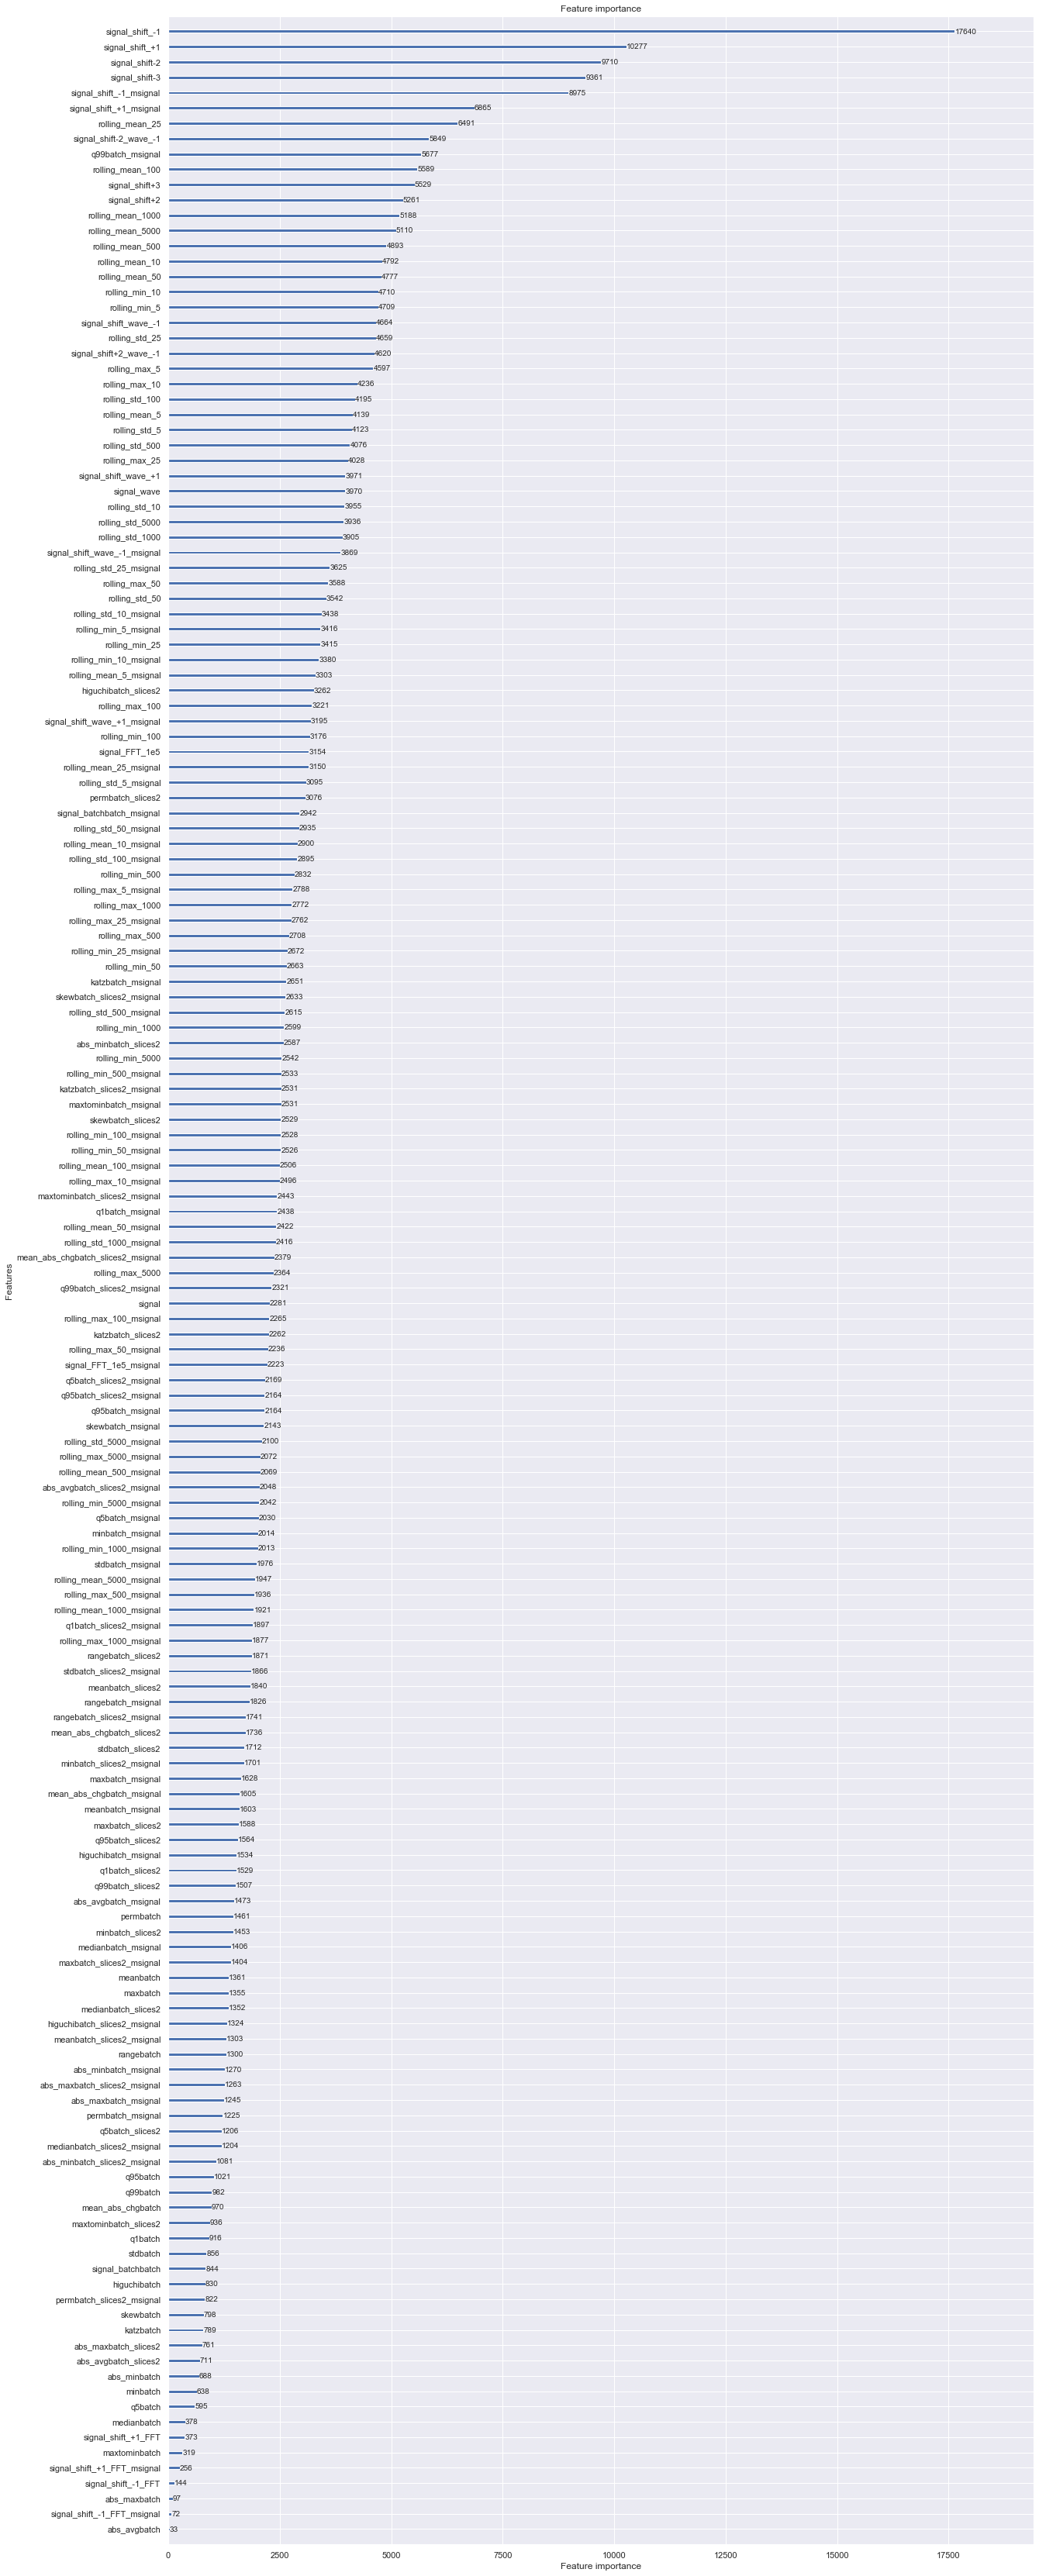

In [24]:
lgb.plot_importance(model,importance_type='split', max_num_features=300, figsize=(20, 60))